# **Value Iteration**

*Created by Pulkit Rustagi, Jeff Jewett, Will Solow, 2024
Oregon State AIGSA Reading Group*

This Google Colab notebook is made to help students understand and visualize process of value iteration, to solve a Markov Decision Process (MDP) using the example of a grid maze.

# **Run this block to install and import dependencies**

In [ ]:
"""Install requisite packages"""
!pip install gymnasium[classic-control]
!pip install numpy
!pip install matplotlib
"""Import packages"""
import io
import time
import gymnasium as gym
import ipywidgets
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# **Utility functions**

In [ ]:
"""Utility functions"""
def image_to_bytes(img):
  if isinstance(img, np.ndarray):
    img = Image.fromarray(img, 'RGB')

  # Convert the PIL image to bytes
  with io.BytesIO() as output:
    img.save(output, format="PNG")
    image_data = output.getvalue()
  return image_data

def matrix_to_heatmap_image(matrix, output_size=(512, 512),display_val=False):
  norm_factor = max(np.abs(np.nanmax(matrix)), np.abs(np.nanmin(matrix)))
  if norm_factor != 0:
    matrix = matrix / norm_factor
  cmap = plt.get_cmap('coolwarm')
  cmap.set_bad(color='black')
  norm = plt.Normalize(vmin=-1, vmax=1)
  rgb_array = cmap(norm(matrix))[:, :, :3]
  rgb_image = Image.fromarray((rgb_array * 255).astype(np.uint8))

  # Resize the image to the specified output size
  resized_image = rgb_image.resize(output_size, Image.NEAREST)

  if display_val:
    # Draw text on the heatmap
    draw = ImageDraw.Draw(resized_image)
    num_rows, num_cols = matrix.shape
    cell_width = output_size[0] / num_cols
    cell_height = output_size[1] / num_rows

    # Overlay text
    for i in range(num_rows):
      for j in range(num_cols):
        value = matrix[i, j]
        # Calculate position for the text
        text_position = (j * cell_width + cell_width / 2, i * cell_height + cell_height / 2)
        text_color = 'black' if value > 0 else 'white'  # Choose text color based on value

        # Draw the text centered in the cell
        draw.text(text_position, f"{value:.1f}", fill=text_color, anchor="mm", font=20)

  return np.array(resized_image)

# **MDP Class**

In [ ]:
class MazeMDP():

  MOVES: dict[int,tuple] = {
         0: np.array([-1, 0]), #UP
         1: np.array([1, 0]),  #DOWN
         2: np.array([0, -1]), #LEFT
         3: np.array([0, 1])   #RIGHT
         }
  UP: int = 0
  DOWN: int = 1
  LEFT: int = 2
  RIGHT: int = 3

  def __init__(self, maze, H=100, gamma=.95):
    """Initialize the MDP"""
    self.maze = np.array(maze)
    assert len(self.maze.shape) == 2, "The maze must be a 2-dimensional array"

    self.obstacles = [tuple(loc) for loc in np.argwhere(self.maze == 1)]
    def get_state_index_from_maze(value):
      locations = [tuple(loc) for loc in np.argwhere(self.maze == value)]
      assert len(locations) == 1, f"There should be exactly one {value} in the maze"
      row, col = locations[0]
      return self.row_col_to_state(row, col)
    self.init_state = get_state_index_from_maze(2)
    self.goal_state = get_state_index_from_maze(3)

    """Create the MDP functions"""
    self.S = set(range(self.maze.shape[0] * self.maze.shape[1]))
    self.A = set(range(len(self.MOVES)))
    self.R = self.build_rewards()
    self.P = self.build_transitions()

    self.H = H
    self.gamma = gamma


  def build_rewards(self):
    """Build reward function"""
    # make every state and action and next state give -1 reward, to penalize long paths
    rewards = np.full((len(self.S), len(self.A), len(self.S)), -1, dtype=float)
    # all actions in the goal state give zero reward
    # this is a requirement for all terminating states
    rewards[self.goal_state, :, :] = 0

    return rewards
  def build_transitions(self):
    """Build transitoins function"""
    transitions = np.zeros((len(self.S), len(self.A), len(self.S)))

    # Go through all states and all actions
    for s in self.S:
      for a in self.A:
        # By default, the next state is the current state
        s_p = s

        # Convert state to maze index
        row_col = np.array(self.state_to_row_col(s))

        # Get new potential state
        row_col_new = row_col + self.MOVES[a]

        # Check that new state is valid
        is_in_bounds = 0 <= row_col_new[0] < self.maze.shape[0] and 0 <= row_col_new[1] < self.maze.shape[1]
        is_free_space = tuple(row_col_new) not in self.obstacles

        # Compute the new s' if the transition is valid
        if is_in_bounds and is_free_space:
          s_p = self.row_col_to_state(*row_col_new)

        # Assign transition probability to 1
        transitions[s,a,s_p] = 1

    return transitions

  def state_to_row_col(self, state):
    """A utility function to get the row and col from a state index"""
    return state // self.maze.shape[1], state % self.maze.shape[1]

  def row_col_to_state(self, row, col):
    """A utility function to get the state index from row and col"""
    return row * self.maze.shape[1] + col

# **Simplified Implementation**

In [ ]:
class MazeMDPNew():

  MOVES: dict[int,tuple] = {
         0: np.array([-1, 0]), #UP
         1: np.array([1, 0]),  #DOWN
         2: np.array([0, -1]), #LEFT
         3: np.array([0, 1])   #RIGHT
         }
  UP: int = 0
  DOWN: int = 1
  LEFT: int = 2
  RIGHT: int = 3

  def __init__(self, maze, H=100, gamma=1):
    """Initialize the MDP"""
    self.maze = np.array(maze)
    assert len(self.maze.shape) == 2, "The maze must be a 2-dimensional array"
    self.obstacles = [tuple(loc) for loc in np.argwhere(self.maze == 1)]

    def get_state_index_from_maze(value):
      locations = [tuple(loc) for loc in np.argwhere(self.maze == value)]
      assert len(locations) == 1, f"There should be exactly one {value} in the maze"
      row, col = locations[0]
      return self.row_col_to_state(row, col)

    self.init_state = get_state_index_from_maze(2)
    self.goal_state = get_state_index_from_maze(3)

    """Create the MDP functions"""
    self.S = set(range(self.maze.shape[0] * self.maze.shape[1]))
    self.A = set(range(len(self.MOVES)))
    self.R = self.get_reward_function()
    self.P = self.get_transition_function()

    self.H = H
    self.gamma = gamma


  def get_reward_function(self):
    """Build reward function"""
    # make every state -1 reward, to penalize long paths
    rewards = np.full((len(self.S)), -1, dtype=float)
    # however goal state reward is 0, so you are not penalized to reach the goal
    rewards[self.goal_state] = 0
    return rewards

  def get_transition_function(self):
    """Build transitoins function"""
    transitions = np.zeros((len(self.S), len(self.A), len(self.S)))

    # Go through all states and all actions
    for s in self.S:
      for a in self.A:
        # By default, the next state is the current state
        s_next = s

        # Convert state to maze index
        state_as_row_col = np.array(self.state_to_row_col(s))

        # Get new potential state
        next_state_as_row_col = state_as_row_col + self.MOVES[a]

        # Check that new state is valid
        next_state_is_in_bounds = (0 <= next_state_as_row_col[0] < self.maze.shape[0]) and (0 <= next_state_as_row_col[1] < self.maze.shape[1])
        next_state_is_free_space = tuple(next_state_as_row_col) not in self.obstacles

        # Compute the new s_next if the transition is valid
        if next_state_is_in_bounds and next_state_is_free_space:
          s_next = self.row_col_to_state(*next_state_as_row_col)

        # Assign transition probability to 1
        transitions[s,a,s_next] = 1

    return transitions

  def state_to_row_col(self, state):
    """A utility function to get the row and col from a state index"""
    return state // self.maze.shape[1], state % self.maze.shape[1]

  def row_col_to_state(self, row, col):
    """A utility function to get the state index from row and col"""
    return row * self.maze.shape[1] + col

# **Gym Environment**


```
Class functions to take note of:
reset(): resets to starting conditions
step(action): takes 'action' at current state to agent
```



In [ ]:
"""Define the Maze Gym Environment"""
class MazeEnv(gym.Env):

  def __init__(self, mdp, render_mode = "ansi"):
    """Initialize the maze environment setting all variables and parsing the map"""
    self.mdp = mdp

    self.agent_curr_state = self.mdp.init_state
    self.steps_taken = 0

    # Set action space and observation space
    self.action_space = gym.spaces.Discrete(len(self.mdp.A))
    self.observation_space = gym.spaces.Discrete(len(self.mdp.S))  # you observe what state you are in

    # Rendering
    self.render_mode = render_mode

  def reset(self):
    """Reset the environment to its initial state"""
    self.agent_curr_state = self.mdp.init_state
    self.steps_taken = 0

    initial_obs = self.agent_curr_state
    initial_info = {}

    return initial_obs, initial_info

  def step(self, action):
    """Take an action in the environment"""

    assert 0 <= action < 4, "Action should be one of [0,1,2,3]"
    s = self.agent_curr_state
    s_next = self.agent_curr_state
    # Sample next state weighted by transition probabilities
    s_next = np.random.choice(list(self.mdp.S), 1, p=self.mdp.P[s, action,:])[0]
    self.agent_curr_state = s_next

    # Get reward according the state you are in
    # reminder of Bellman equation:  V(s) = R(s) + sum T(s,a,s_next).V(s_next)
    reward = self.mdp.R[s]

    # Make outputs for gym environment
    next_obs = s_next

    self.steps_taken += 1
    has_reached_goal = (s_next == self.mdp.goal_state)
    has_reached_time_limit = (self.steps_taken >= self.mdp.H)
    terminated = (has_reached_goal or has_reached_time_limit)

    # truncated indicates that the episode was ended due to some external condition
    truncated = False
    # info can contain auxillary information for logging and debugging
    info = {}

    return next_obs, reward, terminated, truncated, info

  def render(self):
    """ Render the environment """

    if self.render_mode == "ansi":
      # ansi is text mode
      return render_text(self.agent_curr_state, self.mdp.maze)
    else:
      raise ValueError(f"Unsupported rendering mode {self.render_mode}")

def render_text(agent_state, maze):
  """Get a text form of the maze"""

  # These are the characters that will render in your maze.
  # 0 = "-" is empty space
  # 1 = "X" is a wall
  # 2 = "-" is the agent starting location. However, it can be rendered as empty space
  # 3 = "G" is the goal location
  # 4 = "T" is a teleporter (you will implement this)
  # extend this list if you add more features
  character_map = ["-", "X", "-", "G", "T"]
  ncols, nrows = maze.shape

  string=f""
  for i in range(ncols):
    for j in range(nrows):
      s = (i * ncols + j)
      if s == agent_state:
        # The agent is displayed as "A"
        string += "A"
      else:
        string += character_map[maze[i, j]]
    string += "\n"

  return string


# **Value Iteration Agent Class**
Bellman Backup

  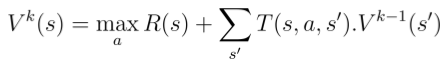

In [ ]:
class ValueIterationAgent():
  """Agent class for solving tabular MDPs"""

  def __init__(self, env):
    """Initialize the agent. env should have a tabular mdp"""

    assert hasattr(env, 'mdp'), "Gymansium Environment does not have associated MDP"

    self.env = env
    self.mdp = env.mdp
    self.policy = None
    self.v = None
    self.v_iterations = []

  def value_iteration(self, epsilon=.000001):
    """Perform value improvement"""
    mdp = self.mdp
    S = mdp.S
    A = mdp.A
    # Randomly initialize v
    # Easiest initialization is all zeros
    v = np.zeros(len(S))

    # Loop until the horizon is reached
    for i in range(mdp.H):

      old_v = v.copy()

      v = np.max(np.sum(mdp.P * (mdp.R + v[np.newaxis, np.newaxis, :]), axis=-1), axis=-1)

      # # Iterate over each state
      # for s in S:
      #   # Iterate over each action
      #   action_values = np.zeros(len(A))
      #   for a in A:  # Store Q-values for each action
      #     q_value = 0
      #     # Iterate over next states to calculate expected value
      #     for next_s in S:
      #       transition_prob = mdp.P[s, a, next_s]  # Probability of transitioning to next_s
      #       reward = mdp.R[s, a, next_s]  # Reward for taking action a in state s, ending in next_s
      #       q_value += transition_prob * (reward + old_v[next_s])  # Bellman equation with reward

      #     action_values[a] = q_value  # Store Q-value for action a

      #   # Update the value function for state s
      #   v[s] = np.max(action_values)  # Take the max over actions
      #   self.v_iterations.append(v)

      # Set goal state value to 0
      v[mdp.goal_state] = 0
      self.v_iterations.append(v)
      # Exit if threshold is reached
      if i > 30 and np.max(np.abs(old_v-v)) < epsilon:
        break

    # Determine the best actions with bellman backups
    action_reward = np.sum(mdp.P * (mdp.R + mdp.gamma * v[np.newaxis, np.newaxis, :]), axis=-1)

    # Compute the optimal policy
    best_actions = (action_reward - np.max(action_reward, axis=1)[:,np.newaxis]) == 0
    policy = best_actions * (1 / np.sum( best_actions, axis=1)[:,np.newaxis])

    self.policy = policy
    self.v = v

    return policy, v

  def get_action(self, state):
    """Get the action given by the policy"""

    # If policy is none, return a random action
    if self.policy is None:
      print("Warning: Value iteration policy has not been computed yet")
      return self.env.action_space.sample()

    # Get the action given by the policy
    action = np.random.choice(list(self.mdp.A), 1, p=self.policy[state,:])[0]

    return action

  def get_value(self, state):
    """Get the value of a given state"""

    return self.v[state]

  def get_value_heatmap(self, agent_state, output_shape=(256,256)):
    """Gets a matrix of all the state values"""
    value_matrix = self.v.reshape((self.mdp.maze.shape))
    # arr = np.nan_to_num(arr, nan=10000)
    for loc in self.mdp.obstacles:
      value_matrix[loc] = np.nan
    image = matrix_to_heatmap_image(value_matrix, output_shape)
    # draw agent
    agent_frac_x = (agent_state // self.mdp.maze.shape[1] + 0.5) / self.mdp.maze.shape[0]
    agent_frac_y = (agent_state % self.mdp.maze.shape[1] + 0.5) / self.mdp.maze.shape[1]
    x_half_width = output_shape[0] / self.mdp.maze.shape[0] * 0.25
    y_half_width = output_shape[1] / self.mdp.maze.shape[1] * 0.25
    min_x = int(output_shape[0] * agent_frac_x - x_half_width)
    max_x = int(output_shape[0] * agent_frac_x + x_half_width)
    min_y = int(output_shape[1] * agent_frac_y - y_half_width)
    max_y = int(output_shape[1] * agent_frac_y + y_half_width)
    image[min_x:max_x, min_y:max_y,:] = 255
    return image


  def get_value_iteration_heatmap(self, v_iteration, output_shape=(256,256)):
    """Gets a matrix of all the state values"""
    value_matrix = v_iteration.reshape((self.mdp.maze.shape))
    # arr = np.nan_to_num(arr, nan=10000)
    for loc in self.mdp.obstacles:
      value_matrix[loc] = np.nan
    image = matrix_to_heatmap_image(value_matrix, output_shape)
    return image


## **Visualize values updates from value iteration**

In [ ]:
STEPS_PER_SECOND = 2
output = ipywidgets.Output()
image_widget = ipywidgets.Image()
display(image_widget)
display(output)

# Create our MDP to specify the maze

# Create the maze MDP.
#       0 is free space,
#       1 is walls,
#       2 is the starting location,
#       3 is the goal location
mdp = MazeMDP([[2,0,0,0,0],
               [1,0,0,1,0],
               [0,0,0,0,0],
               [0,1,0,1,1],
               [0,0,0,0,3]])

# Create the maze gym environment
maze_env = MazeEnv(mdp)

# Create and call a value iteration agent
agent = ValueIterationAgent(maze_env)
V, policy = agent.value_iteration()

terminated = truncated = done = False
obs, info = maze_env.reset()
num_steps = 0

# Assuming agent.v_iterations is a list of value arrays for each iteration
for i, v in enumerate(agent.v_iterations):
  # Reshape the value array to match the maze dimensions
  value_matrix = v.reshape(mdp.maze.shape)
  # print(value_matrix)
  value_heatmap = agent.get_value_iteration_heatmap(value_matrix)
  image_widget.value = image_to_bytes(value_heatmap)

  time.sleep(3/STEPS_PER_SECOND)
  num_steps += 1

print(f"Finished in {num_steps} steps")
# print(agent.v_iterations)

Image(value=b'')

Output()

Finished in 832 steps


## **Visualize agent using value iteration**

In [ ]:
STEPS_PER_SECOND = 2
output = ipywidgets.Output()
image_widget = ipywidgets.Image()
display(image_widget)
display(output)

# Create our MDP to specify the maze

# Create the maze MDP.
#       0 is free space,
#       1 is walls,
#       2 is the starting location,
#       3 is the goal location
mdp = MazeMDP([[2,0,0,0,0],
               [1,0,0,1,0],
               [0,0,0,0,0],
               [0,1,0,1,1],
               [0,0,0,0,3]])

# Create the maze gym environment
maze_env = MazeEnv(mdp)

# Create and call a value iteration agent
agent = ValueIterationAgent(maze_env)
agent.value_iteration()

terminated = truncated = done = False
state, info = maze_env.reset()
num_steps = 0

# Run the maze environment until the episode terminates
while not done and num_steps < 100:
  # Get best action from the agent policy
  action = agent.get_action(state)

  next_state, reward, terminated, truncated, info = maze_env.step(action)
  done = terminated or truncated
  state = next_state

  # Render
  with output:
    clear_output(wait=True)
    print(maze_env.render())
  value_heatmap = agent.get_value_heatmap(state)
  image_widget.value = image_to_bytes(value_heatmap)

  time.sleep(1/STEPS_PER_SECOND)
  num_steps += 1

print(f"Finished in {num_steps} steps")
# print(agent.v_iterations)

Image(value=b'')

Output()

Finished in 8 steps


# **Optimal agent in a larger grid**

In [ ]:
STEPS_PER_SECOND = 2
output = ipywidgets.Output()
image_widget = ipywidgets.Image()
display(image_widget)
display(output)

# Create the alternate reward MDP. Select a maze.
gamma = 0.95
maze = [[2,0,0,0,0,1,0,0,0,0],
        [1,1,1,1,0,1,0,1,0,1],
        [0,0,0,0,0,1,0,1,0,0],
        [0,1,1,1,0,1,0,1,0,1],
        [0,0,0,1,0,0,0,1,0,0],
        [0,1,0,0,0,0,1,0,0,0],
        [0,1,1,1,1,1,1,1,0,1],
        [0,0,0,1,0,0,0,0,0,3],
        [0,1,0,0,0,0,1,1,1,0],
        [0,1,0,0,1,0,0,0,0,0],]

mdp = MazeMDP(maze, gamma=0.95)

# Create the maze gym environment
maze_env = MazeEnv(mdp)

# Create and call a value iteration agent
agent = ValueIterationAgent(maze_env)
agent.value_iteration()

terminated = truncated = done = False
obs, info = maze_env.reset()
num_steps = 0
total_reward = 0

# Run the maze environment until the episode terminates
while not done and num_steps < 40:
  # Get best action from the agent policy
  action = agent.get_action(obs)

  next_obs, reward, terminated, truncated, info = maze_env.step(action)
  done = terminated or truncated
  obs = next_obs
  total_reward += reward

  # Render
  with output:
    clear_output(wait=True)
    print(maze_env.render())
    print(f'Action: {["Up","Down","Left","Right"][action]} ({action})')
  value_heatmap = agent.get_value_heatmap(obs)
  image_widget.value = image_to_bytes(value_heatmap)

  time.sleep(1/STEPS_PER_SECOND)
  num_steps += 1

print(f"Finished in {num_steps} steps with {total_reward} reward")

Image(value=b'')

Output()

Finished in 24 steps with [[-24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24.
  -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24.
  -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24.
  -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24.
  -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24.
  -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24.
  -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24.
  -24. -24.]
 [-24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24.
  -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24.
  -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24.
  -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24.
  -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24.
  -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24. -24.
  -24. -24. -24. -24. -24